#  variables and Functions 

## 1st part 
Definition of variables and keplerSolver(t_obs) function

In [10]:
################################
#Imports
################################
import numpy as np 
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.time import Time


################################
# VARIABLES
################################
R = 6378 * u.km                   # Earth's Radius
a = 1.30262 * R                   # "Circular" radius
e = 0.16561                       # Eccentricity
mu = 398600.4405 * u.km**3 / u.s**2 # Earth's G * M
w = 15 * u.deg                    # Omega (argument of pericenter)
t_p = Time('2025-03-31T00:00:00', format='isot', scale='utc')
t   = Time('2025-04-01T00:00:00', format='isot', scale='utc')

In [11]:

def keplerSolver(t_obs):
    """
    Solves Kepler's equation E - e*sin(E) - l = 0 for the eccentric anomaly E
    using the Newton-Raphson method to find the roots of the problem.

    """
    delta_t = (t_obs - t_p).sec # delta t in seconds
    # Compute mean anomaly l (l = sqrt(mu/a^3)*(t - t_p))
    l = np.sqrt(mu / (a**3))
    mean_anomaly = (l * delta_t).value  # scalar (dimensionless)
    
    # We use Kepler's equation and it's derivative:
    f = lambda E: E - e * np.sin(E) - mean_anomaly
    f_der = lambda E: 1 - e * np.cos(E)
    
    # Newton-Raphson iteration
    E = 1000.0  # initial guess
    max_iter =1000
    epsilon = 1e-10
    for i in range(max_iter):
        f_E = f(E)
        if np.abs(f_E) < epsilon:
            break
        E = E - f_E / f_der(E)
    return E







## 2nd part:
position(t) function

In [12]:
def position(t_obs):
    """
    Returns the radial (r) and angular (phi) position of the satellite at time t_obs.
    """
    E = keplerSolver(t_obs)
    #We find f_angle in terms of E 
    f_angle = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2)) * u.rad
    # we then find r(f) and \phi(f):
    r = a * ((1 - e**2) / (1 + e * np.cos(f_angle)))
    phi = f_angle + w  
    return r, phi

## 3nd part
orbit() function

In [13]:
def orbit():
    """
    Generates and plots the orbit over one period with a 10-second step.
    """
    ### Variables ###
    # Compute total seconds between t and t_p
    #using Kepler's third law
    period = np.sqrt( (4*(np.pi**2)*(a**3))/(mu))
    total_seconds = period.to(u.s).value  # get period in seconds (scalar)
    seconds_array = np.arange(0, total_seconds + 1, 10)
    t_values = t_p + seconds_array * u.s 
    # Defines arrays for r and phi
    r_values = np.zeros(len(t_values))
    phi_values = np.zeros(len(t_values))
    ### Main Loop ###
    for idx, t_val in enumerate(t_values):
        r, phi = position(t_val)
        r_values[idx] = r.value  # r in km
        phi_values[idx] = phi.to(u.rad).value  # convert phi to radians for x,y calculation
    
    # Convert polar coordinates to Cartesian for plotting
    x = r_values * np.cos(phi_values)
    y = r_values * np.sin(phi_values)
    F2_r =  a.value * e
    w_rad = w.to(u.rad).value
    F2_x = F2_r * np.cos(w_rad)
    F2_y = F2_r * np.sin(w_rad)
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=1)
    plt.scatter(0,0)
    plt.scatter(F2_x, F2_y, color='red')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Satellite Orbit')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

##  4th Part 
date(r0) function

In [18]:
def date(r0):
    """
    Given a value r0 the function date(r0) verifies if the position  r0 lies on the orbit of the object, if it does then it proceeds to calculate the time when the object passes through that position.

    """
    # 1. Verify that r0 is reachable: r_peri = a*(1-e) y r_aphe = a*(1+e)
    r_peri = a * (1 - e)
    r_aphe = a * (1 + e)
    if r0 < r_peri or r0 > r_aphe:
        print("The given position is not reachable on the orbit.")
        return None
    
    # 2.We set cos(f) in terms of r 
    #    r0 = a(1-e^2)/(1+e*cos(f))  =>  cos(f) = (a*(1-e^2)/r0 - 1)/e
    cos_f = (a * (1 - e**2) / r0 - 1) / e
    # To avoid numeric errors: we ensure arccos is between [-1, 1]
    cos_f = np.clip(cos_f.value, -1, 1)
    f = np.arccos(cos_f) * u.rad
    print("f is :",np.round(f,4))
    # 3. We calculate tan(E/2) 
    #    tan(E/2) = sqrt((1-e)/(1+e)) * tan(f/2)
    tan_E2 = np.sqrt((1 - e) / (1 + e)) * np.tan((f / 2).value)
    # Then we calculate E 
    E = 2 * np.arctan(tan_E2) * u.rad
    # By calculating the first side of the kepler equation in terms of E we get E - e*sin(E)
    # M(E) = E - esin(E) = l = n*deltaT
    #deltaT = M(E)/n
    E_val = E.value  # whithout units
    M = E_val - e * np.sin(E_val)
    n = np.sqrt(mu / (a**3))
    dt = (M / n.value) * u.s
    t0 = t_p + dt
    return t0


# Code execution :

In [23]:

#For a specific time:
r_sat, phi_sat = position(t)
print("At t =", t.iso, "r =", r_sat, "phi =", phi_sat.to(u.deg))


At t = 2025-04-01 00:00:00.000 r = 9658.64243270032 km phi = 185.66753794159973 deg


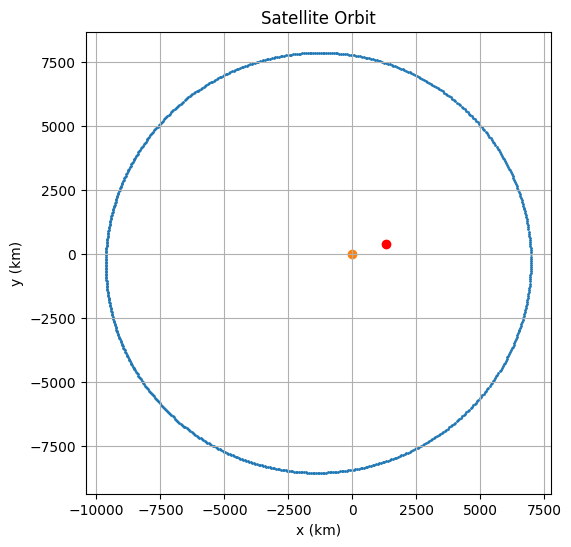

In [19]:
#For a whole period:
orbit()

In [22]:

#For an initial r0:
r0 = 1.5 * R  # Por ejemplo, 1.5 veces el radio de la Tierra
t0 = date(r0)
if t0 is not None:
    print("The satellite reaches r0 =", r0, "at time t0 =", t0.iso)
else:
    print("f")

f is : 2.7887 rad
The satellite reaches r0 = 9567.0 km at time t0 = 2025-03-31 00:53:09.780
